In [1]:
import os
import sys
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

from keras.layers import Flatten, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.losses import categorical_crossentropy

import tensorflow as tf

print(f'Python: {sys.version}')

Python: 3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC v.1929 64 bit (AMD64)]


In [2]:
RANDOM_STATE = 0

In [3]:
# Working with pre trained model 

#base_model = MobileNet(input_shape=(224, 224, 3), include_top=False)
base_model = MobileNet(
    input_shape=None,
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)


for layer in base_model.layers:
  layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(units=52 , activation='softmax')(x)

# creating our model.
model = Model(base_model.input, x)

In [4]:
model.compile(optimizer='adam', loss=categorical_crossentropy , metrics=['accuracy'])

In [5]:
sessions = {}
directory_template = './data/mmi/Sessions/$session$/'
for session in os.listdir('./data/mmi/Sessions'):
    # Find XML filename
    directory = directory_template.replace('$session$', session)
    files = os.listdir(directory)
    xml_filename = directory + files[1]
    
    # Load AUs
    aus = []
    root = ET.parse(xml_filename).getroot()
    for au in root.iter('ActionUnit'):
        aus.append(au.attrib['Number'])
    
    # Load JPG filename
    jpg_filename = directory + files[0]
    
    sessions[session] = {
        'aus': aus,
        'img': jpg_filename
    }
    
assert len(sessions) == 493
print(f'{len(sessions)} sessions loaded')

493 sessions loaded


In [6]:
df_sessions = pd.DataFrame.from_dict(sessions, orient='index')
df_sessions.index.rename('session', inplace=True)

df_sessions_null = df_sessions.loc[df_sessions['aus'].apply(lambda x: len(x)) == 0]
df_sessions = df_sessions.loc[df_sessions['aus'].apply(lambda x: len(x)) != 0]
df_sessions = df_sessions.explode('aus')
df_sessions = df_sessions.sample(frac=1, random_state=RANDOM_STATE)

print(f'df_sessions_null: {df_sessions_null.shape}')
print(f'df_sessions: {df_sessions.shape}')
print()
df_sessions.info()
print()
df_sessions.head()

df_sessions_null: (265, 2)
df_sessions: (568, 2)

<class 'pandas.core.frame.DataFrame'>
Index: 568 entries, 2594 to 2625
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   aus     568 non-null    object
 1   img     568 non-null    object
dtypes: object(2)
memory usage: 13.3+ KB



,aus,img
session,,
2594,27,./data/mmi/Sessions/2594/S014-039.jpg
2565,12,./data/mmi/Sessions/2565/S014-010.jpg
2560,26,./data/mmi/Sessions/2560/S014-005.jpg
2503,36,./data/mmi/Sessions/2503/S004-064.jpg
2411,14,./data/mmi/Sessions/2411/S001-011.jpg


In [7]:
train_datagen = ImageDataGenerator(
    zoom_range = 0.2, 
    shear_range = 0.2, 
    horizontal_flip=True, 
    rescale = 1./255
)
train_data = train_datagen.flow_from_dataframe(
    dataframe = pd.concat([df_sessions] * 5).sample(frac=1),
    directory=".",
    x_col = "img",
    y_col = "aus",
    subset = "training",
    batch_size = 32,
    seed = 42,
    class_mode = "categorical",
    target_size = (128,128)
)

Found 2840 validated image filenames belonging to 52 classes.


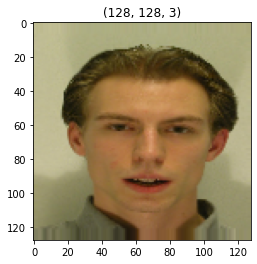

In [8]:
# to visualize the images in the traing data denerator 

t_img , label = train_data.next()

#-----------------------------------------------------------------------------
# function when called will prot the images 
def plotImages(img_arr, label):
  """
  input  :- images array 
  output :- plots the images 
  """
  count = 0
  for im, l in zip(img_arr,label) :
    plt.imshow(im)
    plt.title(im.shape)
    plt.axis = False
    plt.show()
    break

#-----------------------------------------------------------------------------
# function call to plot the images 
plotImages(t_img, label)

In [9]:
hist = model.fit(
    train_data,
    steps_per_epoch=10,
    epochs=30,
    #validation_data=test_data,
    validation_steps=8,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            filepath='./results/model.h5',
            save_best_only=True,
            monitor="accuracy"
        )
    ]
)

print()
max_acc = max(hist.history['accuracy']) * 100
print(f'Accuracy: {max_acc = :.2f}%')

Epoch 1/30
10/10 [==============================] - 7s 572ms/step - loss: 3.9447 - accuracy: 0.0312
Epoch 2/30
10/10 [==============================] - 4s 377ms/step - loss: 3.9302 - accuracy: 0.1000
Epoch 3/30
10/10 [==============================] - 4s 362ms/step - loss: 3.9202 - accuracy: 0.0844
Epoch 4/30
10/10 [==============================] - 3s 340ms/step - loss: 3.9075 - accuracy: 0.0938
Epoch 5/30
10/10 [==============================] - 4s 371ms/step - loss: 3.8948 - accuracy: 0.1594
Epoch 6/30
10/10 [==============================] - 3s 341ms/step - loss: 3.8847 - accuracy: 0.1031
Epoch 7/30
10/10 [==============================] - 3s 340ms/step - loss: 3.8696 - accuracy: 0.1437
Epoch 8/30
10/10 [==============================] - 3s 346ms/step - loss: 3.8564 - accuracy: 0.1923
Epoch 9/30
10/10 [==============================] - 3s 339ms/step - loss: 3.8674 - accuracy: 0.1058
Epoch 10/30
10/10 [==============================] - 3s 331ms/step - loss: 3.8420 - accuracy: 0.1375